In [5]:
import os
import keras

from keras.preprocessing.image import ImageDataGenerator

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# Limits GPU-RAM usage
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
epochs = 50
batch_size = 5
target_width = 150
target_height = 150
target_size = (target_width, target_height)
target_shape = (target_width, target_height, 3) # 3 for color
base_dir = 'Course notebooks\paintings'

In [8]:
def get_generator(base_dir, folderName):
    directory = os.path.join(base_dir, folderName)
    return ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory, 
        target_size, 
        batch_size= batch_size,
        shuffle=True,
        class_mode='sparse'
    )

In [9]:
train_gen = get_generator(base_dir, 'train')
test_gen = get_generator(base_dir, 'test')
validation_gen = get_generator(base_dir, 'validation')

Found 210 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [10]:
numOfClasses = train_gen.num_classes

numOfTrainSamples = train_gen.n
numOfTestSamples = test_gen.n
numOfValSamples = validation_gen.n

In [11]:
# Define Conv model

In [12]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape= target_shape) # honestly, I'm not sure whether height or width comes first

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
block3_pool_width = 18
block3_pool_height = 18
block3_pool_area = block3_pool_width * block3_pool_height
block3_pool_no_of_filters = 256

## Following not used, but included for completeness and your own possible experiments
block5_pool_width = 4
block5_pool_height = 4
block5_pool_area = block3_pool_width * block3_pool_height
block5_pool_no_of_filters = 512

In [15]:
from keras import Model

intermediate_layer_model = Model(inputs=conv_base.input, 
                                 outputs=conv_base.get_layer('block3_pool').output)
no_of_filters_left = 100

In [16]:
from keras.utils.np_utils import to_categorical

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, block3_pool_width, block3_pool_height, block3_pool_no_of_filters))
    labels = np.zeros(shape=(sample_count))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = intermediate_layer_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break

    ### Now throwing away most of the features (= results of features)
    features = features[:,:,:,0:no_of_filters_left]
    ### convert labels 0, 1, and 2 to [1,0,0], [0,1,0] and [0,0,1] 
    labels = to_categorical(labels)
    return features, labels

In [17]:
import numpy as np

train_features, train_labels = extract_features(train_gen, numOfTrainSamples)

validation_features, validation_labels = extract_features(validation_gen, numOfValSamples)

test_features, test_labels = extract_features(test_gen, numOfTestSamples)

In [18]:
train_features = np.reshape(train_features, (numOfTrainSamples, block3_pool_area * no_of_filters_left))
validation_features = np.reshape(validation_features, (numOfValSamples, block3_pool_area * no_of_filters_left))
test_features = np.reshape(test_features, (numOfTestSamples, block3_pool_area * no_of_filters_left))

In [19]:
# Define Dense model

In [20]:
from keras import models
from keras.layers import InputLayer, Flatten, Dense, Dropout

def get_model(shape, nClasses):
    return keras.Sequential([
        InputLayer(input_shape=shape),
        #Flatten(),    ### Need to flatten if dense NN else if ConvNet no need to flatten.
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dense(nClasses, activation='sigmoid'),
    ],)

In [21]:
input_shape = (block3_pool_area * no_of_filters_left, ) # needs the ", " in the end for the InputLayer in the model
model = get_model(input_shape, numOfClasses)

In [22]:
# train model

In [23]:
from keras import optimizers

model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=2e-5), metrics=["acc"])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1036832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 1,037,123
Trainable params: 1,037,123
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(
    train_features, 
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_features, validation_labels))

Train on 210 samples, validate on 60 samples
Epoch 1/50
210/210 [==============================] - 1s 3ms/step - loss: 3.4240 - acc: 0.5492 - val_loss: 1.1643 - val_acc: 0.5500
Epoch 2/50
210/210 [==============================] - 1s 2ms/step - loss: 1.4669 - acc: 0.5556 - val_loss: 0.7967 - val_acc: 0.5778
Epoch 3/50
210/210 [==============================] - 1s 2ms/step - loss: 0.7802 - acc: 0.6460 - val_loss: 0.7454 - val_acc: 0.6556
Epoch 4/50
210/210 [==============================] - 1s 2ms/step - loss: 0.6798 - acc: 0.6651 - val_loss: 0.7264 - val_acc: 0.6722
Epoch 5/50
210/210 [==============================] - 1s 2ms/step - loss: 0.6849 - acc: 0.6444 - val_loss: 0.6567 - val_acc: 0.6889
Epoch 6/50
210/210 [==============================] - 1s 2ms/step - loss: 0.6255 - acc: 0.6778 - val_loss: 0.6639 - val_acc: 0.6556
Epoch 7/50
210/210 [==============================] - 1s 2ms/step - loss: 0.6162 - acc: 0.6587 - val_loss: 0.6473 - val_acc: 0.6944
Epoch 8/50
210/210 [===========

In [26]:
#model.save('baseline.h5')

In [27]:
# validation

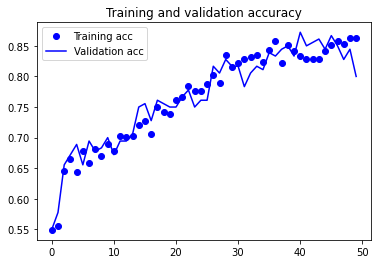

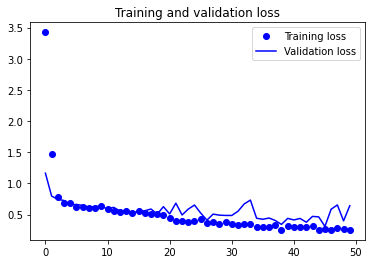

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# BELOW ARE NOW FUNCTIONS TO TRY TO SELECT PRIMING PICTURES

In [30]:
# get the n best pictures for priming, based on nextPicture()
def getPrimingPictures(basePictures, number):
    primingPictures = []
    pictures = basePictures.copy()
    for n in range(number):
        nextP = nextPicture(pictures, primingPictures)
        primingPictures.append(nextP) ## need to append result of the next best performing picture
        pictures.remove(nextP)
    return primingPictures

In [31]:
# find the next picture to include in priming, based on getScore() and bestResult()
def nextPicture(pictures, primingPictures):
    scores = []
    for p in pictures:
        if p not in primingPictures:
            pSet = [p]
            pSet.extend(primingPictures)
            score = getScore(pSet, pictures)
            scores.append({'picture': p, 'score': score})
    #results = getScores(pictures, primingPictures)
    best = bestResult(scores)
    return  best['picture']

In [32]:
# placeholder for defining a score... should be history obejct from model.fit()
def getScore(pSet, pictures):
    model = get_model((150,150,3), 1)
    model.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["acc"])
    
    history = model.fit(pSet,
        validation_data= pictures,
        epochs= epochs,
        shuffle=True
    )
    return pSet[0] *5

In [33]:
# compare a list of literals with a numeric attribute ['score'], and return the highest.
def bestResult(results):
    best = results[0]
    for r in results:
        if best['score'] < r['score']: best = r
    return best

In [35]:
#train_features
train_labels 

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

In [48]:
def getIndexes(target, labels):
    index = [i for i, x in enumerate(labels) if (x == target).all()]
    return index

In [68]:
def getFeatures(indexes, features):
    results = []
    for i in indexes:
        results.append(features[i])
    return results

In [67]:
monet = [1.,0.,0.]
picasso = [0.,1.,0.]
vangogh = [0.,0.,1.]

monetIndexs   = getIndexes(monet  , train_labels)
picassoIndexs = getIndexes(picasso, train_labels)
vangoghIndexs = getIndexes(vangogh, train_labels)

In [69]:
monetFeatures   = getFeatures(monetIndexs  , train_features)
picassoFeatures = getFeatures(picassoIndexs, train_features)
vangoghFeatures = getFeatures(vangoghIndexs, train_features)

In [72]:
monetFeatures

[array([ 3.12588978,  4.47166443,  0.        , ...,  0.        ,
         0.        , 12.75666618]),
 array([1.66289008, 8.74859715, 0.        , ..., 0.21313936, 0.        ,
        0.0645847 ]),
 array([16.45198059, 24.41899109,  0.        , ...,  1.68983197,
         0.        ,  0.        ]),
 array([8.08447838, 4.11494255, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0.        , 9.02403831, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([4.47808695, 9.07409763, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([8.91722679, 4.96418333, 0.61083186, ..., 0.        , 0.        ,
        0.        ]),
 array([5.40482664, 5.77242374, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([2.60223937, 0.94102311, 0.        , ..., 0.        , 0.        ,
        3.74565887]),
 array([ 2.04092002, 13.33888435,  0.        , ...,  3.28327084,
         0.        ,  0.        ]),
 array([16.73880005,  5.60631371

In [71]:
picassoFeatures

[array([20.88347244, 39.08396149,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([0.        , 0.11108898, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([ 1.86218941,  8.23454285,  0.        , ..., 16.63783073,
         0.        ,  1.59675097]),
 array([ 1.67962587,  4.18246174,  0.        , ...,  0.        ,
         8.76356888, 42.46001053]),
 array([ 4.42796469, 25.01016235, 20.15313911, ...,  0.        ,
         0.        ,  4.42953014]),
 array([ 9.12103081,  8.17111492,  0.        , ..., 29.46818733,
         0.        ,  0.        ]),
 array([13.52811909, 30.27828789, 14.19581699, ...,  9.03566647,
         0.        ,  0.        ]),
 array([19.16801453, 19.4295578 , 17.81674767, ...,  0.        ,
         5.72818613, 12.39498138]),
 array([ 6.4301405 , 20.34052658,  0.        , ..., 17.06307602,
         0.        , 19.66464615]),
 array([ 7.56819439, 25.6537075 ,  0.        , ...,  0.        ,
         0.        ,  7.40952396

In [70]:
vangoghFeatures

[array([13.52931786,  8.29338932,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([14.71216869, 10.78674698,  0.        , ..., 12.0462656 ,
         0.        , 12.68431854]),
 array([ 6.58739614, 11.1338768 ,  6.966043  , ...,  0.        ,
         0.        ,  4.27205324]),
 array([5.46980238, 8.42663956, 0.        , ..., 2.79795313, 0.        ,
        1.6776278 ]),
 array([5.84835672, 9.78743076, 0.        , ..., 0.        , 0.        ,
        0.76916689]),
 array([ 0.70213252,  4.58697653,  0.15672877, ...,  0.        ,
         0.        , 23.10838509]),
 array([2.13958573, 7.05927515, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0.46549493, 5.83760548, 0.        , ..., 0.        , 0.        ,
        3.27337027]),
 array([13.82792091, 26.42788124,  0.        , ...,  0.        ,
         0.        , 14.88421917]),
 array([6.27856207, 1.03453565, 0.        , ..., 0.        , 0.        ,
        3.44437361]),
 array([5.98996496, 